In [36]:
from logging import DEBUG, INFO
from sdsstools import get_logger
from sdsstools.logger import StreamFormatter

logger = get_logger("astro.net")
logger.sh.setLevel(DEBUG)
logger.sh.formatter = StreamFormatter(fmt='%(asctime)s %(name)s \033[1m%(message)s\033[21m')
logger.debug("hello world")


2022-10-19 13:34:02,765 astro.net [DEBUG]: hello world
DEBUG:astro.net:hello world


In [37]:
import astropy
import astrometry

solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={6},
    )
)
# only first iteration
logodds_callback = astrometry.Action.STOP
# full
#logodds_callback = astrometry.Action.CONTINUE


In [38]:
from cluplus.proxy import invoke
from lvmtipo.actors import lvm

telescope_subsystem_name = "sci"
tss = await lvm.from_string(telescope_subsystem_name).start()

await invoke(tss.pwi.status(), tss.km.status())


[{'is_tracking': True,
  'is_connected': True,
  'is_slewing': False,
  'is_enabled': True,
  'ra_j2000_hours': 13.783333260003,
  'dec_j2000_degs': 49.3000007189399,
  'ra_apparent_hours': 13.7977905291188,
  'dec_apparent_degs': 49.1884299800609,
  'altitude_degs': 68.470828049939,
  'azimuth_degs': 282.236331235939,
  'field_angle_rate_at_target_degs_per_sec': -0.00157021322321474,
  'field_angle_here_degs': 76.696039323178,
  'field_angle_at_target_degs': 76.69603968738,
  'axis0': {'dist_to_target_arcsec': -5.06502060801192e-05,
   'is_enabled': True,
   'position_degs': 282.236591097484,
   'rms_error_arcsec': 0.00141052656109569,
   'servo_error_arcsec': 0.0},
  'axis1': {'dist_to_target_arcsec': -4.18947140863366e-05,
   'is_enabled': True,
   'position_degs': 68.4704246884474,
   'rms_error_arcsec': 0.00217969145586579,
   'servo_error_arcsec': 0.0},
  'model': {'filename': '',
   'num_points_enabled': 0,
   'num_points_total': 0,
   'rms_error_arcsec': 0.0},
  'geometry': 0},

2022-10-19 14:27:27,288 astro.net [DEBUG]: Expose
DEBUG:astro.net:Expose


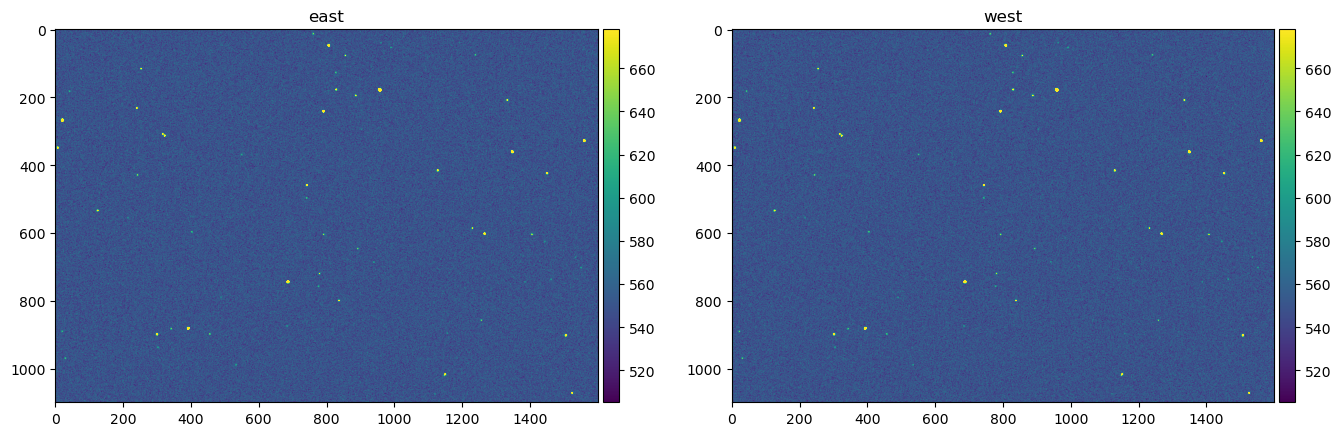

In [41]:
from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection

from plotimg import plot_images

# define source detection
source_detection = SepSourceDetection()
#source_detection = DaophotSourceDetection()

logger.debug("Expose")
filenames = (await tss.agc.expose(15)).flatten().unpack("*.filename") 
images = [Image.from_file(f) for f in filenames]
image = images[0]

plot_images(images)


In [43]:
arcsec_per_pixel=1/image.header['PIXELSC']*image.header['BINX']

print(f"{image.header['RA']=}")
print(f"{image.header['DEC']=}")
print(f"{arcsec_per_pixel=}")

logger.debug("Source detect")
image = await source_detection(image)
if image.catalog is None:
    logger.warning("No catalog found in image.")
    
logger.debug("Sort")

source_count = 17
sources = image.catalog
sources.sort("peak")
sources.reverse()
sources = sources[:source_count]
#print(sources)

logger.debug("Solve start")
solution = solver.solve(
    stars_xs=sources['x'],
    stars_ys=sources['y'],
    size_hint=astrometry.SizeHint(
        lower_arcsec_per_pixel=arcsec_per_pixel-0.5,
        upper_arcsec_per_pixel=arcsec_per_pixel+0.5,
    ),
    position_hint=astrometry.PositionHint(
        ra_deg=image.header['RA'],
        dec_deg=image.header['DEC'],
        radius_deg=1,
    ),
    solve_id=None,
    tune_up_logodds_threshold=14.0, # None disables tune-up (SIP distortion)
    output_logodds_threshold=21.0,
    logodds_callback=lambda logodds_list: logodds_callback
)
logger.debug("Solve done")

if solution.has_match():
    print(f"{solution.best_match().center_ra_deg=}")
    print(f"{solution.best_match().center_dec_deg=}")
    print(f"{solution.best_match().scale_arcsec_per_pixel=}")
    wcs = astropy.wcs.WCS(solution.best_match().wcs_fields)
    pixels = wcs.all_world2pix(
        [[star.ra_deg, star.dec_deg] for star in solution.best_match().stars],
        0,
    )
    #print(f"{wcs}")

2022-10-19 16:37:06,828 astro.net [DEBUG]: Source detect
DEBUG:astro.net:Source detect
2022-10-19 16:37:06,938 astro.net [DEBUG]: Sort
DEBUG:astro.net:Sort
2022-10-19 16:37:06,943 astro.net [DEBUG]: Solve start
DEBUG:astro.net:Solve start


image.header['RA']=206.749999653498
image.header['DEC']=49.3000035609316
arcsec_per_pixel=0.9910669005614712


2022-10-19 16:37:07,752 astro.net [DEBUG]: Solve done
DEBUG:astro.net:Solve done


solution.best_match().center_ra_deg=207.372004818112
solution.best_match().center_dec_deg=49.01386206746636
solution.best_match().scale_arcsec_per_pixel=0.9999655661007366
